<a href="https://colab.research.google.com/github/AbbasRahimi/netgan/edit/testing/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'c:\users\abbasrahimi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [10]:
#!pip install python-igraph

You should consider upgrading via the 'c:\users\abbasrahimi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [1]:
#import tensorflow as tf
from netgan.netgan import *
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


#### Load the data

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/small_DS.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [4]:
print('A:', type(_A_obs), '\n', _A_obs)
print('X:', type(_X_obs), '\n', _X_obs)
print('z:', type(_z_obs), '\n', _z_obs)

A: <class 'scipy.sparse.csr.csr_matrix'> 
   (0, 1)	1
  (0, 2)	1
  (0, 4)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 39)	1
  (2, 0)	1
  (2, 1)	1
  (2, 3)	1
  (3, 1)	1
  (3, 2)	1
  (3, 4)	1
  (4, 0)	1
  (4, 1)	1
  (4, 3)	1
  (4, 6)	1
  (5, 6)	1
  (5, 38)	1
  (6, 4)	1
  (6, 5)	1
  (7, 8)	1
  (7, 20)	1
  (7, 21)	1
  :	:
  (29, 27)	1
  (29, 31)	1
  (30, 28)	1
  (30, 32)	1
  (30, 39)	1
  (31, 22)	1
  (31, 29)	1
  (31, 33)	1
  (31, 38)	1
  (32, 30)	1
  (32, 34)	1
  (33, 31)	1
  (34, 32)	1
  (34, 35)	1
  (35, 34)	1
  (36, 39)	1
  (37, 20)	1
  (38, 5)	1
  (38, 8)	1
  (38, 15)	1
  (38, 31)	1
  (39, 1)	1
  (39, 10)	1
  (39, 30)	1
  (39, 36)	1
X: <class 'scipy.sparse.csr.csr_matrix'> 
   (0, 1)	0.1
  (0, 4)	0.4
  (1, 2)	0.2
  (1, 3)	0.3
  (2, 0)	0.05
  (2, 1)	0.3
  (3, 2)	0.05
  (4, 1)	0.1
  (4, 3)	0.3
  (5, 6)	0.6
  (6, 4)	0.4
  (7, 8)	0.4
  (7, 20)	0.2
  (7, 21)	0.3
  (8, 15)	0.05
  (9, 16)	0.3
  (10, 39)	0.05
  (11, 10)	0.1
  (12, 11)	0.3
  (13, 18)	0.6
  (14, 12)	0.4
  (15, 19)	0.4
 

In [5]:
val_share = 0.1
test_share = 0.05
#seed = 481516234

#### Separate the edges into train, test, validation

In [6]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, undirected=True, connected=True, asserts=True)

In [7]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

In [8]:
print(train_graph)

  (0, 1)	1.0
  (0, 2)	1.0
  (0, 4)	1.0
  (1, 0)	1.0
  (1, 3)	1.0
  (1, 4)	1.0
  (1, 39)	1.0
  (2, 0)	1.0
  (3, 1)	1.0
  (4, 0)	1.0
  (4, 1)	1.0
  (4, 6)	1.0
  (5, 6)	1.0
  (5, 38)	1.0
  (6, 4)	1.0
  (6, 5)	1.0
  (7, 8)	1.0
  (7, 20)	1.0
  (7, 21)	1.0
  (8, 7)	1.0
  (8, 38)	1.0
  (9, 16)	1.0
  (10, 11)	1.0
  (10, 39)	1.0
  (11, 10)	1.0
  :	:
  (29, 27)	1.0
  (29, 31)	1.0
  (30, 28)	1.0
  (30, 32)	1.0
  (30, 39)	1.0
  (31, 22)	1.0
  (31, 29)	1.0
  (31, 33)	1.0
  (31, 38)	1.0
  (32, 30)	1.0
  (32, 34)	1.0
  (33, 31)	1.0
  (34, 32)	1.0
  (34, 35)	1.0
  (35, 34)	1.0
  (36, 39)	1.0
  (37, 20)	1.0
  (38, 5)	1.0
  (38, 8)	1.0
  (38, 15)	1.0
  (38, 31)	1.0
  (39, 1)	1.0
  (39, 10)	1.0
  (39, 30)	1.0
  (39, 36)	1.0


#### Parameters

In [10]:
rw_len = 5
batch_size = 32

In [12]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [13]:
walker.walk().__next__()

array([[23, 25, 15, 38, 15],
       [33, 31, 29, 31, 33],
       [17, 27, 29, 31, 33],
       [38, 15, 19, 15, 25],
       [26, 16, 26, 16, 20],
       [24, 15, 24, 15, 38],
       [17, 27, 17, 27, 17],
       [ 7, 20, 37, 20, 23],
       [27, 17, 27, 17, 27],
       [19, 15, 24, 15, 38],
       [24, 15, 24, 15, 19],
       [ 0,  4,  1,  0,  4],
       [16,  9, 16, 26, 16],
       [23, 20, 23, 20,  7],
       [ 6,  5, 38,  5, 38],
       [ 4,  1,  3,  1,  4],
       [ 0,  4,  6,  5,  6],
       [11, 10, 11, 10, 11],
       [29, 27, 17, 27, 17],
       [36, 39, 36, 39, 10],
       [ 7,  8, 38, 15, 24],
       [32, 30, 32, 30, 28],
       [11, 10, 11, 10, 11],
       [26, 16, 20, 23, 25],
       [19, 15, 19, 15, 19],
       [25, 23, 25, 15, 19],
       [20, 37, 20, 21,  7],
       [23, 20, 16,  9, 16],
       [35, 34, 35, 34, 35],
       [19, 15, 19, 15, 19],
       [ 7, 21, 20,  7,  8],
       [ 9, 16, 20, 16, 20]], dtype=int64)

#### Create our NetGAN model

In [14]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=32, W_down_generator_size=32,batch_size=32,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[10], discriminator_layers=[8], temp_start=5, learning_rate=0.003)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the inter

c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  wa

#### Define the stopping criterion

In [15]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [16]:
eval_every = 100
plot_every = 100

**** Using VAL criterion for early stopping ****
**** Saving snapshots into ../snapshots/model_best_2.ckpt ****
**** Initializing... ****
**** Done.           ****
**** Starting training. ****
**** Iter 100    Val ROC 0.480, AP: 0.630, EO 0.080 ****
**** Iter 200    Val ROC 0.600, AP: 0.687, EO 0.140 ****
**** Iter 300    Val ROC 0.600, AP: 0.659, EO 0.140 ****
**** Iter 400    Val ROC 0.800, AP: 0.786, EO 0.180 ****
**** Iter 500    Val ROC 0.880, AP: 0.903, EO 0.280 ****
**** Iter 600    Val ROC 0.880, AP: 0.925, EO 0.380 ****
**** Iter 700    Val ROC 0.880, AP: 0.925, EO 0.400 ****
**** Iter 800    Val ROC 0.840, AP: 0.911, EO 0.420 ****
**** Iter 900    Val ROC 0.800, AP: 0.871, EO 0.480 ****
**** Training completed after 999 iterations. ****
INFO:tensorflow:Restoring parameters from ../snapshots/model_best_2.ckpt


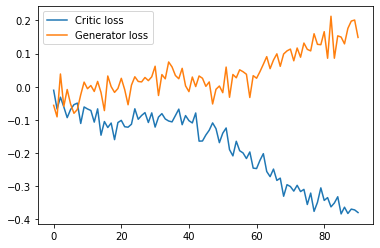

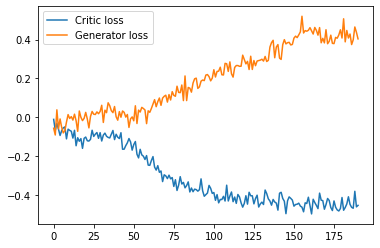

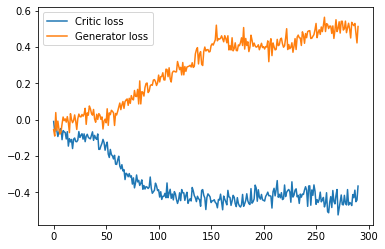

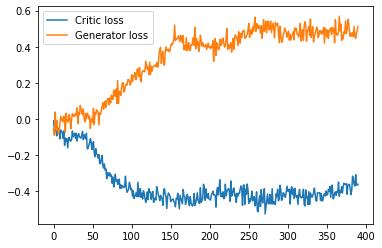

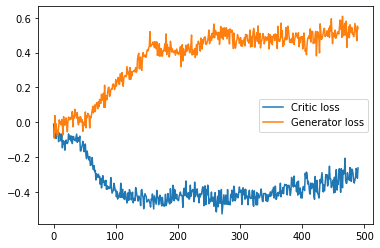

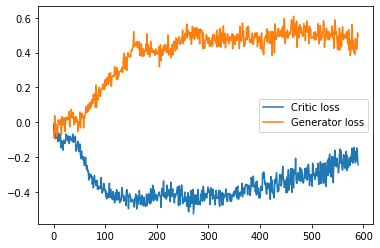

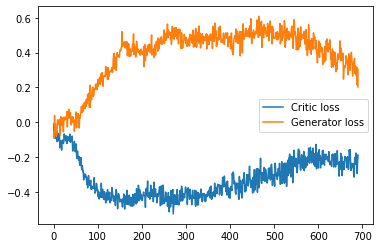

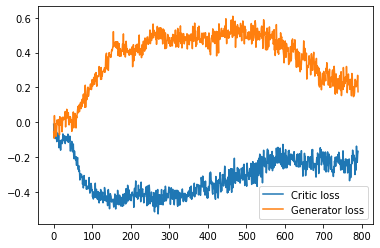

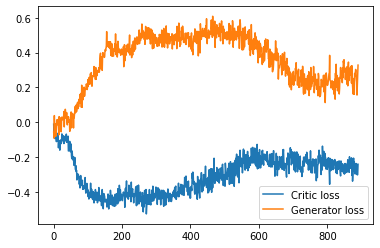

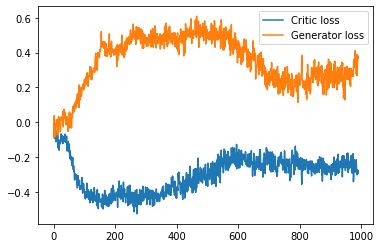

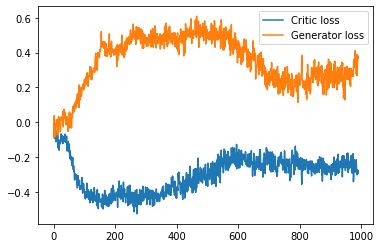

In [17]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, plot_every=plot_every, max_patience=5, max_iters=1000)

In [18]:
log_dict.keys()

dict_keys(['disc_losses', 'gen_losses', 'val_performances', 'edge_overlaps', 'generated_graphs'])

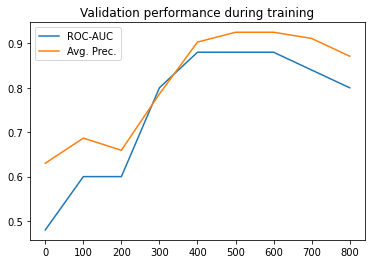

In [19]:
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
         np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
         np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

plt.title("Validation performance during training")
plt.legend()
plt.show()

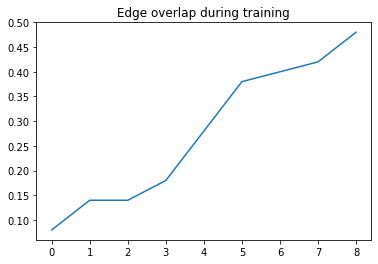

In [20]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [21]:
sample_many = netgan.generate_discrete(1000, reuse=True)

c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  wa

In [22]:
samples = []

In [23]:
for _ in range(600):
    if (_+1) % 50 == 0:
        print(_)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

49
99
149
199
249
299
349
399
449
499
549
599


#### Assemble score matrix from the random walks

In [24]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()

#### Evaluate generalization via link prediction

In [25]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

In [26]:
roc_auc_score(test_labels, test_scores)

0.5555555555555556

In [27]:
average_precision_score(test_labels, test_scores)

0.5888888888888889